# Reliable uncertainty estimates for neural network predictions

I previously wrote about [Bayesian neural networks](https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/dev/bayesian-neural-networks/bayesian_neural_networks.ipynb) and explained how uncertainty estimates can be obtained for network predictions. Uncertainty in predictions that comes from uncertainty in network weights is called *epistemic uncertainty* or model uncertainty. A simple regression example demonstrated how epistemic uncertainty increases in regions outside the training data distribution:

![Epistemic uncertainty](images/epistemic-uncertainty.png)

A reader later [experimented](https://github.com/krasserm/bayesian-machine-learning/issues/8) with discontinuous ranges of training data and found that uncertainty estimates are lower than expected in training data "gaps", as shown in the following figure near the center of the $x$ axis. In these out-of-distribution (OOD) regions the network is over-confident in its predictions. One reason for this over-confidence is that weight priors usually impose only weak constraints over network outputs in OOD regions.

![Epistemic uncertainty gap](images/epistemic-uncertainty-gap.png)

If we could instead define a prior in data space directly we could better control uncertainty estimates for OOD data. A prior in data space better captures assumptions about input-output relationships than priors in weight space. Including such a prior through a loss in data space would allow a network to learn distributions over weights that better generalize to OOD regions i.e. enables a network to output more reliable uncertainty estimates.

This is exactly what the paper [Noise Contrastive Priors for Functional Uncertainty](http://proceedings.mlr.press/v115/hafner20a.html) does. In this article I'll give an introduction to their approach and demonstrate how it fixes over-confidence in OOD regions. I will again use non-linear regression with one-dimensional inputs as an example and plan to cover higher-demensional inputs in a later article. 

Application of noise contrastive priors (NCPs) is not limited to Bayesian neural networks, they can also be applied to deterministic neural networks. Here, I'll use a Bayesian neural network and implement it with Tensorflow 2 and [Tensorflow Probability](https://www.tensorflow.org/probability).

In [1]:
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Input, Dense, Lambda, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L2
from tensorflow_probability import distributions as tfd
from tensorflow_probability import layers as tfpl
from scipy.stats import norm

from utils import (train,
                   backprop,
                   select_bands, 
                   select_subset,
                   style,
                   plot_data, 
                   plot_prediction, 
                   plot_uncertainty)

%matplotlib inline
logging.getLogger('tensorflow').setLevel(logging.ERROR)

## Training dataset

In [2]:
rng = np.random.RandomState(123)

The training dataset are 40 noisy samples from a sinusoidal function `f` taken from two distinct regions of the input space (red dots). The gray dots illustrate how the noise level increases with $x$ (heteroskedastic noise). 

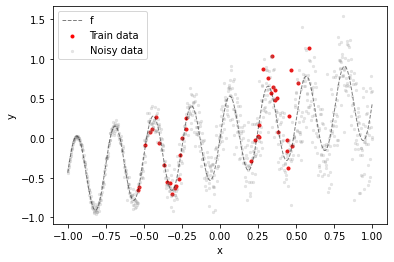

In [3]:
def f(x):
    """Sinusoidal function."""
    return 0.5 * np.sin(25 * x) + 0.5 * x


def noise(x, slope, rng=np.random):
    """Create heteroskedastic noise."""
    noise_std = np.maximum(0.0, x + 1.0) * slope
    return rng.normal(0, noise_std).astype(np.float32)

x = np.linspace(-1.0, 1.0, 1000, dtype=np.float32).reshape(-1, 1)
x_test = np.linspace(-1.5, 1.5, 200, dtype=np.float32).reshape(-1, 1)

# Noisy samples from f (with heteroskedastic noise)
y = f(x) + noise(x, slope=0.2, rng=rng)

# Select data from 2 of 5 bands (regions)
x_bands, y_bands = select_bands(x, y, mask=[False, True, False, True, False])

# Select 40 random samples from these regions
x_train, y_train = select_subset(x_bands, y_bands, num=40, rng=rng)

plot_data(x_train, y_train, x, f(x))
plt.scatter(x, y, **style['bg_data'], label='Noisy data')
plt.legend();

Goal is to have a model that outputs lower epistemic uncertainty in training data regions and higher epistemic uncertainty in all other regions, including training data "gaps". In addition to estimating epistemic uncertainty the model should also estimate *aleatoric uncertainty* i.e. the heteroskedastic noise in the training data. 

## Noise contrastive estimation

The algorithm developed by the authors of the NCP paper is inspired by [noise contrastive estimation](http://proceedings.mlr.press/v9/gutmann10a.html) (NCE). With noise contrastive estimation a model learns to recognize patterns in training data by contrasting them to random noise. Instead of training a model on training data alone it is trained in context of a binary classification task with the goal of discriminating training data from noise data sampled from an artificial noise distribution. 

Hence, in addition to a trained model, NCE also obtains a binary classifier that can estimate the probability of input data to come from the training distribution or from the noise distribution. This can be used to obtain more reliable uncertainty estimates. For example, a higher probability that an input comes from the noise distribution should result in higher model uncertainty.

Samples from a noise distribution are often obtained by adding random noise to training data. These samples represent OOD data. In practice it is often sufficient to have OOD samples *near* the boundary of the training data distribution to also get reliable uncertainty estimates in other regions of the OOD space. Noise contrastive priors are based on this hypothesis.

## Noise contrastive priors

A noise contrastive prior for regression is a joint *data prior* $p(x, y)$ over input $x$ and output $y$. Using the product rule of probability, $p(x, y) = p(x)p(y \mid x)$, it can be defined as the product of an *input prior* $p(x)$ and an *output prior* $p(y \mid x)$. 

The input prior describes the distribution of OOD data $\tilde{x}$ that are generated from the training data $x$ by adding random noise epsilon i.e. $\tilde{x} = x + \epsilon$ where $\epsilon \sim \mathcal{N}(0, \sigma_x^2)$. The input prior can therefore be defined as the convolved distribution:

$$
p_{nc}(\tilde{x}) = {1 \over N} \sum_{i=1}^N \mathcal{N}(\tilde{x} - x_i \mid 0, \sigma_x^2)
\tag{1}
$$

where $x_i$ are the inputs from the training dataset and $\sigma_x$ is a hyper-parameter. As described in the paper, models trained with NCPs are quite robust to the size of input noise $\sigma_x$. The following figure visualizes the distribution of training inputs and OOD inputs as histograms, the orange line is the input prior density.

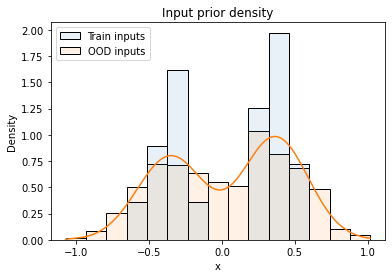

In [4]:
def perturbe_x(x, y, sigma_x, n=100):
    """Perturbe input x with noise sigma_x (n samples)."""
    ood_x = x + np.random.normal(scale=sigma_x, size=(x.shape[0], n))
    ood_y = np.tile(y, n)    
    return ood_x.reshape(-1, 1), ood_y.reshape(-1, 1)
    
def input_prior_density(x, x_train, sigma_x):
    """Compute input prior density of x."""
    return np.mean(norm(0, sigma_x).pdf(x - x_train.reshape(1, -1)), axis=1, keepdims=True)

sigma_x = 0.2
sigma_y = 1.0

ood_x, ood_y = perturbe_x(x_train, y_train, sigma_x, n=25)
ood_density = input_prior_density(ood_x, x_train, sigma_x)

sns.lineplot(x=ood_x.ravel(), y=ood_density.ravel(), color='tab:orange');
sns.histplot(data={'Train inputs': x_train.ravel(), 'OOD inputs': ood_x.ravel()}, 
                   element='bars', stat='density', alpha=0.1, common_norm=False)

plt.title('Input prior density')
plt.xlabel('x');

The definition of the output prior is motivated by *data augmentation*. A model should be encouraged to not only predict target $y$ at training input $x$ but also predict the same target at perturbed input $\tilde{x}$ that has been generated from $x$ by adding noise. The output prior is therefore defined as:


$$
p_{nc}(\tilde{y} \mid \tilde{x}) = \mathcal{N}(\tilde{y} \mid y, \sigma_y^2)
\tag{2}
$$

$\sigma_y$ is a hyper-parameter that should cover relatively high prior uncertainty in model output given OOD input. The joint prior $p(x, y)$ is best visualized by sampling values from it and doing a kernel-density estimation from these samples (a density plot from an analytical evaluation is rather "noisy" because of the data augmentation setting).

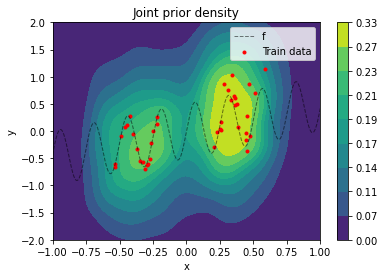

In [5]:
def output_prior_dist(y, sigma_y):
    """Create output prior distribution (data augmentation setting)."""
    return tfd.Independent(tfd.Normal(y.ravel(), sigma_y))

def sample_joint_prior(ood_x, output_prior, n):
    """Draw n samples from joint prior at ood_x."""
    x_sample = np.tile(ood_x.ravel(), n)
    y_sample = output_prior.sample(n).numpy().ravel()
    return x_sample, y_sample

output_prior = output_prior_dist(ood_y, sigma_y)
x_samples, y_samples = sample_joint_prior(ood_x, output_prior, n=10)

sns.kdeplot(x=x_samples, y=y_samples, 
            levels=10, thresh=0, 
            fill=True, cmap='viridis', 
            cbar=True, cbar_kws={'format': '%.2f'},
            gridsize=100, clip=((-1, 1), (-2, 2)))
plot_data(x_train, y_train, x, f(x))
plt.title('Joint prior density')
plt.legend();

## Regression models

The regression models used in the following subsections are probabilistic models $p(y \mid x)$ parameterized by the outputs of a neural network given input $x$. All networks have two hidden layers with leaky ReLU activations and 200 units each. The details of the output layers are described along with the individual models. I will first demonstrate how two models without NCPs fail to produce reliable uncertainty estimates in OOD regions and then show how NCPs can fix that.

### Deterministic neural network without NCPs

A regression model that uses a deterministic neural network for parameterization can be defined as $p(y \mid x, \boldsymbol{\theta}) = \mathcal{N}(y \mid \mu(x, \boldsymbol{\theta}), \sigma^2(x, \boldsymbol{\theta}))$. Mean $\mu$ and standard deviation $\sigma$ are functions of input $x$ and network weights $\boldsymbol{\theta}$. In a deterministic neural network, $\boldsymbol{\theta}$ are point estimates. Outputs at input $x$ can be generated by sampling from $p(y \mid x, \boldsymbol{\theta})$ where $\mu(x,\boldsymbol{\theta})$ is the expected value of the sampled outputs and $\sigma^2(x, \boldsymbol{\theta})$ their variance. The variance represents aleatoric uncertainty. 

Given a training dataset $\mathbf{x}, \mathbf{y} = \left\{ x_i, y_i \right\}$ and using $\log p(\mathbf{y} \mid \mathbf{x}, \boldsymbol{\theta}) = \sum_i \log p(y_i \mid x_i, \boldsymbol{\theta})$, a maximum likelihood (ML) estimate of $\boldsymbol{\theta}$ can be obtained by minimizing the negative log likelihood.

$$
L(\boldsymbol{\theta}) = - \log p(\mathbf{y} \mid \mathbf{x},\boldsymbol{\theta})
\tag{3}
$$

A maximum-a-posteriori (MAP) estimate can be obtained by minimizing the following loss function:

$$
L(\boldsymbol{\theta}) = - \log p(\mathbf{y} \mid \mathbf{x}, \boldsymbol{\theta}) - \lambda \log p(\boldsymbol{\theta})
\tag{4}
$$

where $p(\boldsymbol{\theta})$ is an isotropic normal prior over network weights with zero mean. This is also known as L2 regularization with regularization strength $\lambda$.

The following implementation uses the `DistributionLambda` layer of Tensorflow Probability to produce $p(y \mid x, \boldsymbol{\theta})$ as model output. The `loc` and `scale` parameters of that distribution are set from the output of layers `mu` and `sigma`, respectively. Layer `sigma` uses a [softplus](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)#Softplus) activation function to ensure non-negative output.

In [6]:
def create_model(n_hidden=200, regularization_strength=0.01):
    l2_regularizer = L2(regularization_strength)
    leaky_relu = LeakyReLU(alpha=0.2)

    x_in = Input(shape=(1,))
    x = Dense(n_hidden, activation=leaky_relu, kernel_regularizer=l2_regularizer)(x_in)
    x = Dense(n_hidden, activation=leaky_relu, kernel_regularizer=l2_regularizer)(x)
    m = Dense(1, name='mu')(x)
    s = Dense(1, activation='softplus', name='sigma')(x)
    d = Lambda(lambda p: tfd.Normal(loc=p[0], scale=p[1] + 1e-5))((m, s))

    return Model(x_in, d)

In [7]:
model = create_model()

To reduce overfitting of the model to the relatively small training set an L2 regularizer is added to the kernel of the hidden layers. The value of the corresponding regularization term in the loss function can be obtained via `model.losses` during training. The negative log likelihood is computed with the `log_prob` method of the distribution returned from a `model` call.

In [8]:
@tf.function
def train_step(model, optimizer, x, y):
    with tf.GradientTape() as tape:
        out_dist = model(x, training=True)
        nll = -out_dist.log_prob(y)
        reg = model.losses
        loss = tf.reduce_sum(nll) + tf.reduce_sum(reg)

    optimizer.apply_gradients(backprop(model, loss, tape))
    return loss, out_dist.mean()

With this specific regression model, we can only predict aleatoric uncertainty via $\sigma(x, \boldsymbol{\theta})$ but not epistemic uncertainty. After training the model, we can plot the expected output $\mu$ together with aleatoric uncertainty. Aleatoric uncertainty increases in training data regions as $x$ increases but is not reliable in OOD regions.

In [9]:
train(model, x_train, y_train, batch_size=10, epochs=4000, step_fn=train_step)

epoch 1000: loss = 2.188, mse = 0.114
epoch 2000: loss = -2.775, mse = 0.061
epoch 3000: loss = -4.832, mse = 0.045
epoch 4000: loss = -5.896, mse = 0.039


In [10]:
out_dist = model(x_test)

aleatoric_uncertainty=out_dist.stddev()
expected_output = out_dist.mean()

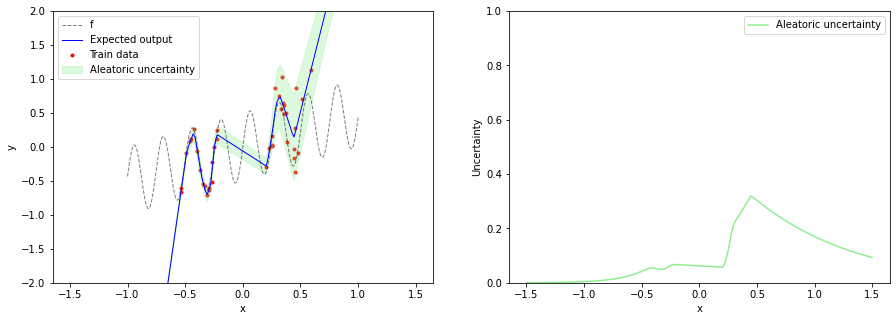

In [11]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plot_data(x_train, y_train, x, f(x))
plot_prediction(x_test, 
                expected_output, 
                aleatoric_uncertainty=aleatoric_uncertainty)
plt.ylim(-2, 2)
plt.legend()

plt.subplot(1, 2, 2)
plot_uncertainty(x_test, 
                 aleatoric_uncertainty=aleatoric_uncertainty)
plt.ylim(0, 1)
plt.legend();

### Bayesian neural network without NCPs

In a Bayesian neural network, we infer a posterior distribution $p(\mathbf{w} \mid \mathbf{x}, \mathbf{y})$ over weights $\mathbf{w}$ given training data $\mathbf{x}$, $\mathbf{y}$ instead of making point estimates with ML or MAP. In general, the true posterior $p(\mathbf{w} \mid \mathbf{x}, \mathbf{y})$ is untractable for a neural network and is often approximated with a variational distribution $q(\mathbf{w} \mid \boldsymbol{\theta}, \mathbf{x}, \mathbf{y})$ or $q(\mathbf{w} \mid \boldsymbol{\theta})$ for short. You can find an introduction to Bayesian neural networks and variational inference in [this article](https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/dev/bayesian-neural-networks/bayesian_neural_networks.ipynb).

Following the conventions in the linked article, I'm using the variable $\mathbf{w}$ for neural network weights that are random variables and $\boldsymbol{\theta}$ for the parameters of the variational distribution and for neural network weights that are deterministic variables. This distinction is useful for models that use both, variational and deterministic layers. 

Here, we will implement a variational approximation only for the `mu` layer i.e. for the layer that produces the expected output $\mu(x, \mathbf{w}, \boldsymbol{\theta})$. This time it additionally depends on weights $\mathbf{w}$ sampled from the variational distribution $q(\mathbf{w} \mid \boldsymbol{\theta})$. The variational distribution $q(\mathbf{w} \mid \boldsymbol{\theta})$ therefore induces a distribution over the expected output $q(\mu \mid x, \boldsymbol{\theta}) = \int \mu(x, \mathbf{w}, \boldsymbol{\theta}) q(\mathbf{w} \mid \boldsymbol{\theta}) d\mathbf{w}$. 

To generate an output at input $x$ we first sample from the variational distribution $q(\mathbf{w} \mid \boldsymbol{\theta})$ and then use that sample as input for $p(y \mid x, \mathbf{w}, \boldsymbol{\theta}) = \mathcal{N}(y \mid \mu(x, \mathbf{w}, \boldsymbol{\theta}), \sigma^2(x, \boldsymbol{\theta}))$ from which we finally sample an output value $y$. The variance of output values covers both epistemic and aleatoric uncertainty where aleatoric uncertainty is contributed by $\sigma^2(x, \boldsymbol{\theta})$. The mean of $\mu$ is the expected value of output $y$ and the variance of $\mu$ represents epistemic uncertainty i.e. model uncertainty.

Since the true posterior $p(\mathbf{w} \mid \mathbf{x}, \mathbf{y})$ is untractable in the general case the predictive distribution $p(y \mid x, \boldsymbol{\theta}) = \int p(y \mid x, \mathbf{w}, \boldsymbol{\theta}) q(\mathbf{w} \mid \boldsymbol{\theta}) d\mathbf{w}$ is untractable too and cannot be used directly for optimizing $\boldsymbol{\theta}$. In the special case of Bayesian inference for layer `mu` only, there should be a tractable solution (I think) but we will assume the general case here and use variational inference. The loss function is therefore the negative variational lower bound.

$$
L(\boldsymbol{\theta}) = - \mathbb{E}_{q(\mathbf{w} \mid \boldsymbol{\theta})} \log p(\mathbf{y} \mid \mathbf{x}, \mathbf{w}, \boldsymbol{\theta}) + \mathrm{KL}(q(\mathbf{w} \mid \boldsymbol{\theta}) \mid\mid p(\mathbf{w}))
\tag{5}
$$

The expectation w.r.t. $q(\mathbf{w} \mid \boldsymbol{\theta})$ is approximated via sampling in a forward pass. In a [previous article](https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/dev/bayesian-neural-networks/bayesian_neural_networks.ipynb) I implemented that with a custom `DenseVariational` layer, here I'm using `DenseReparameterization` from Tensorflow Probability. Both model the variational distribution over weights as factorized normal distribution $q(\mathbf{w} \mid \boldsymbol{\theta})$ and produce a stochastic weight output by sampling from that distribution. They only differ in some implementation details.

In [12]:
def create_model(n_hidden=200):
    leaky_relu = LeakyReLU(alpha=0.2)
    
    x_in = Input(shape=(1,))
    x = Dense(n_hidden, activation=leaky_relu)(x_in)
    x = Dense(n_hidden, activation=leaky_relu)(x)
    m = tfpl.DenseReparameterization(1, name='mu')(x)
    s = Dense(1, activation='softplus', name='sigma')(x)
    d = Lambda(lambda p: tfd.Normal(loc=p[0], scale=p[1] + 1e-5))((m, s))

    return Model(x_in, d)

In [13]:
model = create_model()

The implementation of the loss function follows directly from Equation $(5)$. The KL divergence is added by the variational layer to the `model` object and can be obtained via `model.losses`. When using mini-batches the KL divergence must be divided by the number of batches per epoch. Because of the small training dataset, the KL divergence is further multiplied by `0.1` to lessen the influence of the prior. The likelihood term of the loss function i.e. the first term in Equation $(5)$ is computed via the distribution returned by the model.

In [14]:
train_size = x_train.shape[0]
batch_size = 10
batches_per_epoch = train_size / batch_size

kl_weight = 1.0 / batches_per_epoch

# Further reduce regularization effect of KL term
# in variational lower bound since we only have a 
# small training set (to prevent that posterior
# over weights collapses to prior).
kl_weight = kl_weight * 0.1

@tf.function
def train_step(model, optimizer, x, y, kl_weight=kl_weight):
    with tf.GradientTape() as tape:
        out_dist = model(x, training=True)
        nll = -out_dist.log_prob(y)
        kl_div = model.losses[0]
        loss = tf.reduce_sum(nll) + kl_weight * kl_div
        
    optimizer.apply_gradients(backprop(model, loss, tape))
    return loss, out_dist.mean()

After training, we run the test input `x_test` several times through the network to obtain samples of the stochastic output of layer `mu`. From these samples we compute the mean and variance of $\mu$ i.e. we numerically approximate $q(\mu \mid x, \boldsymbol{\theta})$. The variance of $\mu$ is a measure of epistemic uncertainty. In the next section we'll use an analytical expression for $q(\mu \mid x, \boldsymbol{\theta})$. 

In [15]:
train(model, x_train, y_train, batch_size=batch_size, epochs=8000, step_fn=train_step)

epoch 1000: loss = 10.245, mse = 0.131
epoch 2000: loss = 3.361, mse = 0.094
epoch 3000: loss = 1.265, mse = 0.086
epoch 4000: loss = 0.040, mse = 0.079
epoch 5000: loss = -0.773, mse = 0.069
epoch 6000: loss = -1.527, mse = 0.060
epoch 7000: loss = -2.112, mse = 0.051
epoch 8000: loss = -2.788, mse = 0.043


In [16]:
out_dist = model(x_test)
out_dist_means = []

for i in range(100):
    out_dist = model(x_test)
    out_dist_means.append(out_dist.mean())

aleatoric_uncertainty = model(x_test).stddev()
epistemic_uncertainty = tf.math.reduce_std(out_dist_means, axis=0)
expected_output = tf.reduce_mean(out_dist_means, axis=0)

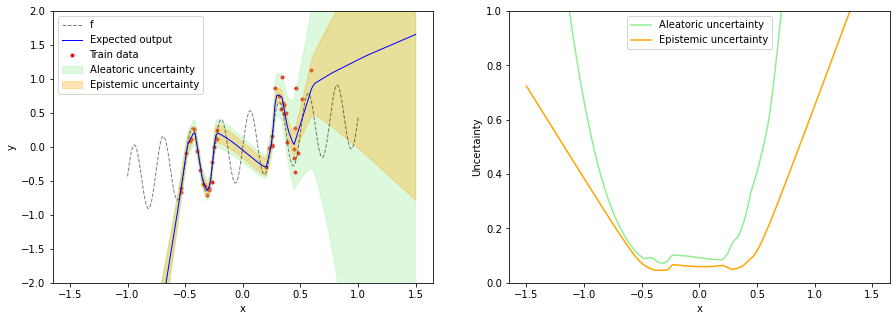

In [17]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plot_data(x_train, y_train, x, f(x))
plot_prediction(x_test, 
                expected_output, 
                aleatoric_uncertainty=aleatoric_uncertainty, 
                epistemic_uncertainty=epistemic_uncertainty)
plt.ylim(-2, 2)
plt.legend()

plt.subplot(1, 2, 2)
plot_uncertainty(x_test, 
                 aleatoric_uncertainty=aleatoric_uncertainty, 
                 epistemic_uncertainty=epistemic_uncertainty)
plt.ylim(0, 1)
plt.legend();

As mentioned in the beginning, a Bayesian neural network with a prior over weights is over-confident in the training data "gap" i.e. in the OOD region between the two training data regions. Our intuition tells us that epistemic uncertainty should be higher here. Also the model is over-confident of a linear relationship for input values less than `-0.5`.

### Bayesian neural network with NCPs

Regularizing the variational posterior $q(\mathbf{w} \mid \boldsymbol{\theta})$ to be closer to a prior over weights $p(\mathbf{w})$ by minimizing the KL divergence in Equation $(5)$ doesn't seem to generalize well to all OOD regions. But, as mentioned in the previous section, the variational distribution $q(\mathbf{w} \mid \boldsymbol{\theta})$ induces a distribution $q(\mu \mid x, \boldsymbol{\theta})$ in data space which allows comparison to a noise contrastive prior that is also defined in data space.

In particular, for OOD input $\tilde{x}$, sampled from a noise contrastive input prior $p_{nc}(\tilde{x})$, we want the mean distribution $q(\mu \mid \tilde{x}, \boldsymbol{\theta})$ to be close to a *mean prior* $p_{nc}(\tilde{y} \mid \tilde{x})$ which is the output prior defined in Equation $(2)$. In other words, the expected output and epistemic uncertainty should be close to the mean prior for OOD data. This can be achieved by reparameterizing the KL divergence in weight space as KL divergence in output space by replacing $q(\mathbf{w} \mid \boldsymbol{\theta})$ with $q(\mu \mid \tilde{x}, \boldsymbol{\theta})$ and $p(\mathbf{w})$ with $p_{nc}(\tilde{y} \mid \tilde{x})$. Using an OOD dataset $\mathbf{\tilde{x}}, \mathbf{\tilde{y}}$ derived from a training dataset $\mathbf{x}, \mathbf{y}$ the loss function is

$$
L(\boldsymbol{\theta}) \approx - \mathbb{E}_{q(\mathbf{w} \mid \boldsymbol{\theta})} \log p(\mathbf{y} \mid \mathbf{x}, \mathbf{w}, \boldsymbol{\theta}) + \mathrm{KL}(q(\boldsymbol{\mu} \mid \mathbf{\tilde{x}}, \boldsymbol{\theta}) \mid\mid p_{nc}(\mathbf{\tilde{y}} \mid \mathbf{\tilde{x}}))
\tag{6}
$$


This is an approximation of Equation $(5)$ for reasons explained in Appendix B of the paper. For their experiments, the authors use the opposite direction of the KL divergence without having found a significant difference i.e. they used the loss function

$$
L(\boldsymbol{\theta}) = - \mathbb{E}_{q(\mathbf{w} \mid \boldsymbol{\theta})} \log p(\mathbf{y} \mid \mathbf{x}, \mathbf{w}, \boldsymbol{\theta}) + \mathrm{KL}(p_{nc}(\mathbf{\tilde{y}} \mid \mathbf{\tilde{x}}) \mid\mid q(\boldsymbol{\mu} \mid \mathbf{\tilde{x}}, \boldsymbol{\theta}))
\tag{7}
$$

This allows an interpretation of the KL divergence as fitting the mean distribution to an empirical OOD distribution (derived from the training dataset) via maximum likelihood using data augmentation. Recall how the definition of $p_{nc}(\tilde{y} \mid \tilde{x})$ in Equation $(2)$ was motivated by data augmentation. The following implementation uses the loss function defined in Equation $(7)$.

Since we have a variational approximation only in the linear `mu` layer we can derive an anlytical expression for $q(\mu \mid \tilde{x}, \boldsymbol{\theta})$ using the parameters $\boldsymbol{\theta}$ of the variational distribution $q(\mathbf{w} \mid \boldsymbol{\theta})$ and the output of the second hidden layer (`inputs` in code below). The corresponding implementation is in the (inner) function `mean_dist`. The model is extended to additionally return the mean distribution.

In [18]:
def mean_dist_fn(variational_layer):
    def mean_dist(inputs):
        # Assumes that a deterministic bias variable 
        # is used in variational_layer
        bias_mean = variational_layer.bias_posterior.mean()
        
        # Assumes that a random kernel variable
        # is used in variational_layer
        kernel_mean = variational_layer.kernel_posterior.mean()
        kernel_std = variational_layer.kernel_posterior.stddev()

        # A Gaussian over kernel k in variational_layer induces
        # a Gaussian over output 'mu' (where mu = inputs * k + b):
        #
        # - q(k) = N(k|k_mean, k_std^2)
        #
        # - E[inputs * k + b] = inputs * E[k] + b
        #                     = inputs * k_mean + b
        #                     = mu_mean
        #
        # - Var[inputs * k + b] = inputs^2 * Var[k]
        #                       = inputs^2 * k_std^2
        #                       = mu_var
        #                       = mu_std^2
        #
        # -q(mu) = N(mu|mu_mean, mu_std^2)
        
        mu_mean = tf.matmul(inputs, kernel_mean) + bias_mean
        mu_var = tf.matmul(inputs ** 2, kernel_std ** 2)
        mu_std = tf.sqrt(mu_var)
        
        return tfd.Normal(mu_mean, mu_std)
    return mean_dist


def create_model(n_hidden=200):
    leaky_relu = LeakyReLU(alpha=0.2)
    variational_layer = tfpl.DenseReparameterization(1, name='mu')
    
    x_in = Input(shape=(1,))
    x = Dense(n_hidden, activation=leaky_relu)(x_in)
    x = Dense(n_hidden, activation=leaky_relu)(x)
    m = variational_layer(x)
    s = Dense(1, activation='softplus', name='sigma')(x)
    mean_dist = Lambda(mean_dist_fn(variational_layer))(x)
    out_dist = Lambda(lambda p: tfd.Normal(loc=p[0], scale=p[1] + 1e-5))((m, s))

    return Model(x_in, [out_dist, mean_dist])

In [19]:
model = create_model()

With the mean distribution returned by the model, the KL divergence can be computed analytically. For models with more variational layers we cannot derive an anayltical expression for $q(\mu \mid \tilde{x}, \boldsymbol{\theta})$ and have to estimate the KL divergence using samples from the mean distribution i.e. using the stochastic output of layer `mu` directly. The following implementation computes the KL divergence analytically.

In [20]:
@tf.function
def train_step(model, optimizer, x, y, 
               sigma_x=0.5,
               sigma_y=1.0,
               ood_std_noise=0.1, 
               ncp_weight=0.1):
    
    # Generate random OOD data from training data
    ood_x = x + tf.random.normal(tf.shape(x), stddev=sigma_x)
    
    # NCP output prior (data augmentation setting)
    ood_mean_prior = tfd.Normal(y, sigma_y)
    
    with tf.GradientTape() as tape:
        # output and mean distribution for training data
        out_dist, mean_dist = model(x, training=True)

        # output and mean distribution for OOD data
        ood_out_dist, ood_mean_dist = model(ood_x, training=True)
        
        # Negative log likelihood of training data
        nll = -out_dist.log_prob(y)
        
        # KL divergence between output prior and OOD mean distribution
        kl_ood_mean = tfd.kl_divergence(ood_mean_prior, ood_mean_dist)
        
        if ood_std_noise is None:
            kl_ood_std = 0.0
        else:
            # Encourage aleatoric uncertainty to be close to a
            # pre-defined noise for OOD data (ood_std_noise)
            ood_std_prior = tfd.Normal(0, ood_std_noise)
            ood_std_dist = tfd.Normal(0, ood_out_dist.stddev())
            kl_ood_std = tfd.kl_divergence(ood_std_prior, ood_std_dist)
        
        loss = tf.reduce_sum(nll + ncp_weight * kl_ood_mean + ncp_weight * kl_ood_std)
        
    optimizer.apply_gradients(backprop(model, loss, tape))
    return loss, mean_dist.mean()

The implementation of the loss function uses an additional term that is not present in  Equation $(7)$. This term is added if `ood_std_noise` is defined. It encourages the aleatoric uncertainty for OOD data to be close to a predefined `ood_std_noise`, a hyper-parameter that we set to a rather low value so that low aleatoric uncertainty is predicted in OOD regions. This makes sense as we can only reasonably estimate aleatoric noise in regions of existing training data.

After training the model we can get the expected output, epistemic uncertainty and aleatoric uncertainty with a single pass of test inputs through the model. The expected output can be obtained from the mean of the mean distribution, epistemic uncertainty from the variance of the mean distribution and aleatoric uncertainty from the variance of the output distribution (= output of the `sigma` layer).

In [21]:
train(model, x_train, y_train, batch_size=10, epochs=15000, step_fn=train_step)

epoch 1000: loss = 160.744, mse = 0.155
epoch 2000: loss = 11.848, mse = 0.152
epoch 3000: loss = 11.350, mse = 0.150
epoch 4000: loss = 10.598, mse = 0.146
epoch 5000: loss = 10.288, mse = 0.137
epoch 6000: loss = 9.587, mse = 0.120
epoch 7000: loss = 8.948, mse = 0.103
epoch 8000: loss = 8.420, mse = 0.087
epoch 9000: loss = 8.008, mse = 0.073
epoch 10000: loss = 7.728, mse = 0.061
epoch 11000: loss = 7.521, mse = 0.054
epoch 12000: loss = 7.242, mse = 0.050
epoch 13000: loss = 7.034, mse = 0.047
epoch 14000: loss = 6.911, mse = 0.043
epoch 15000: loss = 6.892, mse = 0.043


In [22]:
out_dist, mean_dist = model(x_test)

aleatoric_uncertainty = out_dist.stddev()
epistemic_uncertainty = mean_dist.stddev()
expected_output = mean_dist.mean()

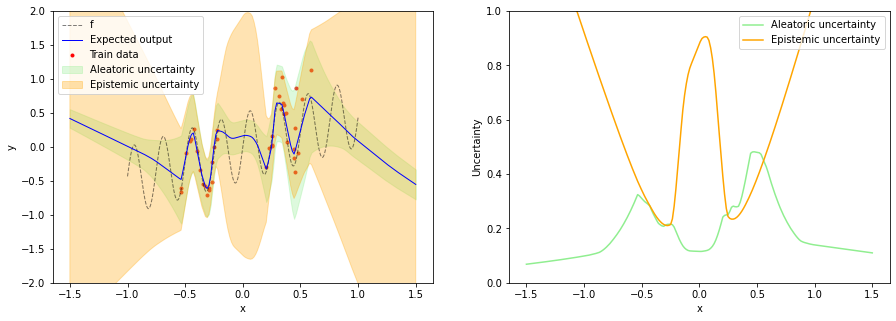

In [23]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plot_data(x_train, y_train, x, f(x))
plot_prediction(x_test, 
                expected_output, 
                aleatoric_uncertainty=aleatoric_uncertainty, 
                epistemic_uncertainty=epistemic_uncertainty)
plt.ylim(-2, 2)
plt.legend()

plt.subplot(1, 2, 2)
plot_uncertainty(x_test, 
                 aleatoric_uncertainty=aleatoric_uncertainty, 
                 epistemic_uncertainty=epistemic_uncertainty)
plt.ylim(0, 1)
plt.legend();

We can see that epistemic uncertainty is now high in *all* OOD regions which fixes the issue mentioned in the beginning. Aleatoric uncertainty increases with increasing x in training data regions while being small in OOD regions. This is useful for e.g. [active learning](https://en.wikipedia.org/wiki/Active_learning_(machine_learning)) where new training data should be sampled in regions of high epistemic uncertainty but low noise. The application of NCPs to active learning is described in more detail in the paper.

## References

- Hafner, D., Tran, D., Irpan, A., Lillicrap, T., and Davidson, J. [Noise Contrastive Priors for Functional Uncertainty](http://proceedings.mlr.press/v115/hafner20a.html). In *Proceedings of The 35th Uncertainty in Artificial Intelligence Conference*, pages 905-914, 2020.

- M. Gutmann and A. Hyvärinen. [Noise-contrastive estimation: A new estimation principle for unnormalized statistical models](http://proceedings.mlr.press/v9/gutmann10a.html). In *Proceedings of the Thirteenth International Conference on Artificial Intelligence and Statistics*, pages 297-304, 2010.

## Acknowledgements

Thanks to Danijar Hafner, Dustin Tran and Christoph Stumpf for useful feedback on a earlier draft.